## # Part 1: Dataset Description and Collection

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os, math, hashlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


# ===== MULTI-ROOT SCAN =====

IMAGE_EXTS = ('.png','.jpg','.jpeg','.tif','.tiff','.bmp')

ROOTS = [
    "/kaggle/input/bach-breast-cancer-histology-images",             
    "/kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge_TestDataset"
]

def scan_root(root, include_thumbnails=True):
    paths, total = [], 0
    thumb_tokens = ("thumb", "thumbnail", "thumbnails", "gt_thumbnails")
    for dp, dn, fn in os.walk(root):
        low = dp.lower()
        if not include_thumbnails and any(tok in low for tok in thumb_tokens):
            continue
        for f in fn:
            if f.lower().endswith(IMAGE_EXTS):
                p = os.path.join(dp, f)
                paths.append(p)
                try:
                    total += os.path.getsize(p)
                except OSError:
                    pass
    return paths, total


per_root = []
all_paths = []
for r in ROOTS:
    ps, sz = scan_root(r,include_thumbnails=True)
    per_root.append({"root": r, "images": len(ps), "size_gb": sz/(1024**3)})
    all_paths.extend(ps)

per_root_df = pd.DataFrame(per_root).sort_values("size_gb", ascending=False).reset_index(drop=True)
display(per_root_df)

total_gb = sum(per_root_df["size_gb"])
print(f"Total number of images: {len(all_paths):,}")
print(f"Total size:   {total_gb:.2f} GB")

# ===== LABEL INFERENCE  =====

LABEL_KEYWORDS = {
    "benign": {"benign"},
    "malignant": {"malignant","cancer","carcinoma","tumor","tumour"},
    "normal": {"normal","control"},
    "invasive": {"invasive"},
    "in_situ": {"in-situ","in_situ","insitu","dcis"},
}
token2lbl = {t:k for k, toks in LABEL_KEYWORDS.items() for t in toks}

def infer_label_from_path(p):
    parts = [x.lower() for x in p.replace("\\","/").split("/")]
    for part in parts:
        if part in token2lbl:
            return token2lbl[part]
    for part in parts:
        for lbl, toks in LABEL_KEYWORDS.items():
            if any(t in part for t in toks):
                return lbl
    parent = os.path.basename(os.path.dirname(p)).lower()
    for lbl, toks in LABEL_KEYWORDS.items():
        if any(t in parent for t in toks):
            return lbl
    return None

# Run on ALL images (for Part-1 totals)
df = pd.DataFrame({"path": all_paths})
df["label"] = df["path"].map(infer_label_from_path)
df.head()

,root,images,size_gb
0,/kaggle/input/bach-breast-cancer-histology-images,550,8.747204
1,/kaggle/input/bach-breast-cancer-histology-ima...,110,1.786091


Total number of images: 660
Total size:   10.53 GB


,path,label
0,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
1,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
2,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
3,/kaggle/input/bach-breast-cancer-histology-ima...,malignant
4,/kaggle/input/bach-breast-cancer-histology-ima...,malignant


## Part 2: Visualization of Data

,count
label,
malignant,260
in_situ,100
benign,100
normal,100
invasive,100


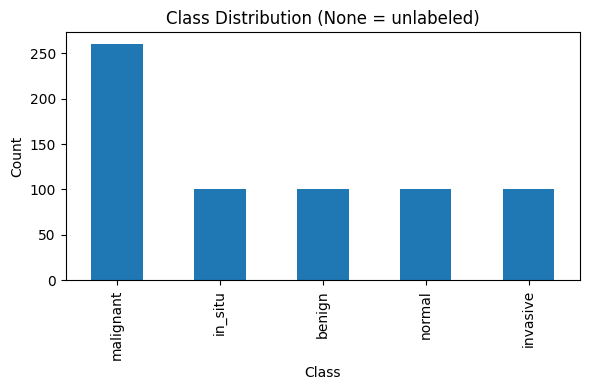

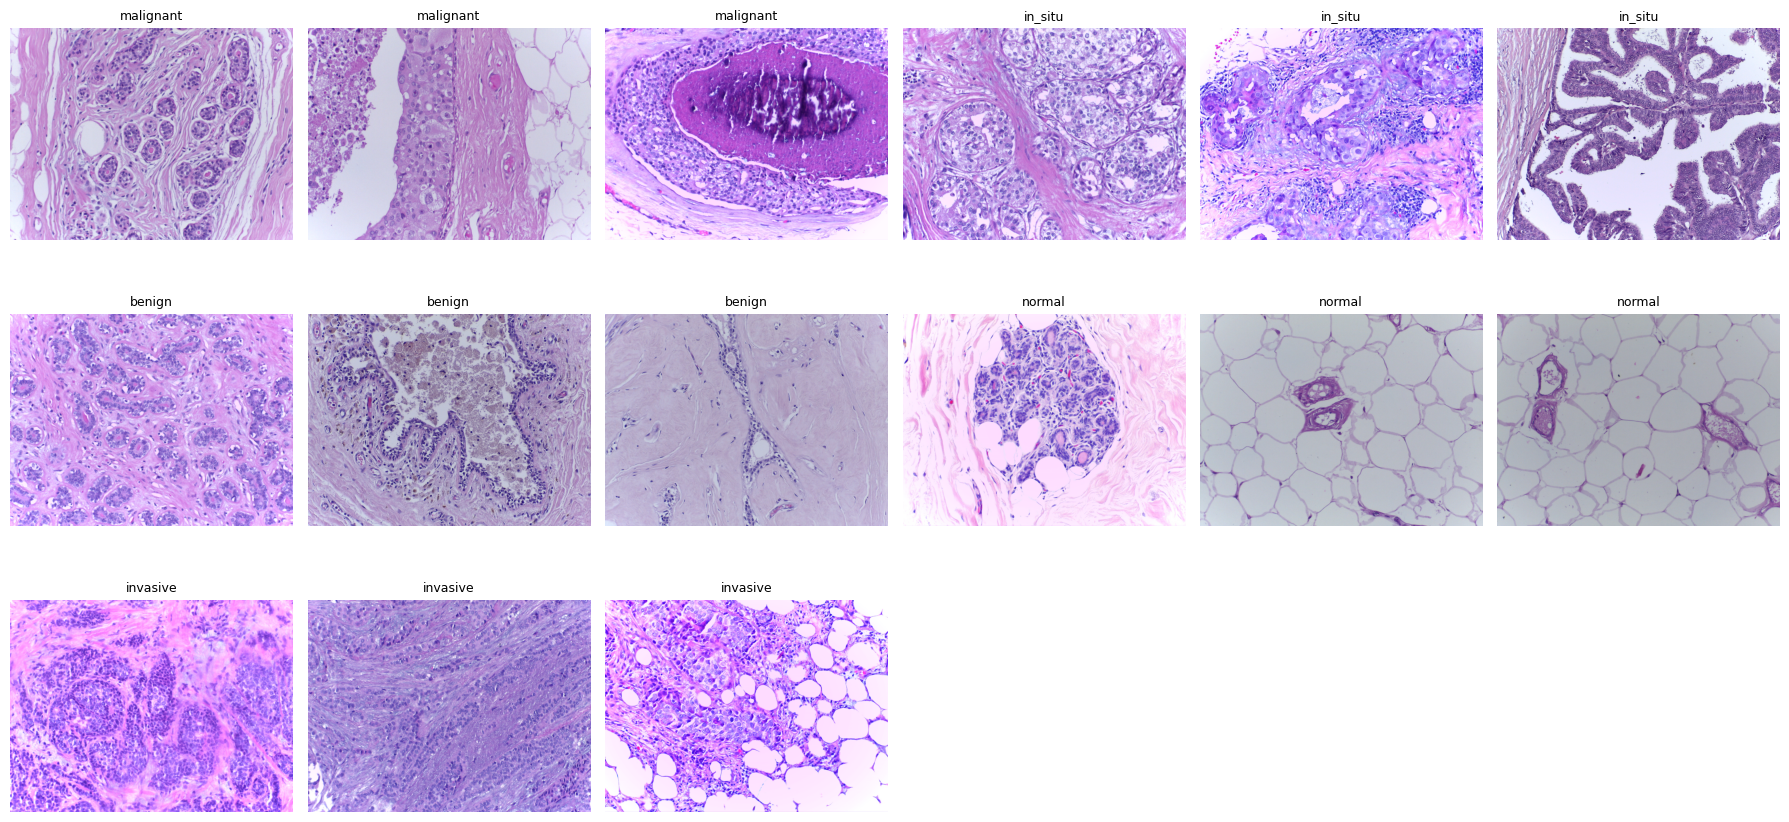

In [7]:
# ===== CLASS DISTRIBUTION + SAMPLE PREVIEWS =====
import matplotlib.pyplot as plt
from PIL import Image
import random

label_counts = df["label"].value_counts(dropna=False)
display(label_counts.to_frame("count"))

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.title("Class Distribution (None = unlabeled)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

def show_samples(df_subset, per_label=3, max_total=12):
    labels = [l for l in df_subset["label"].dropna().unique()]
    picks = []
    if labels:
        for l in labels:
            subset = df_subset[df_subset["label"] == l]["path"].tolist()
            random.shuffle(subset)
            picks += subset[:per_label]
    else:
        paths = df_subset["path"].tolist()
        random.shuffle(paths)
        picks = paths[:max_total]

    cols = min(6, len(picks)); rows = (len(picks)+cols-1)//cols
    plt.figure(figsize=(3*cols, 3*rows))
    for i, p in enumerate(picks, 1):
        try:
            with Image.open(p) as im:
                plt.subplot(rows, cols, i)
                plt.imshow(im); plt.axis("off")
                ttl = infer_label_from_path(p) or "unlabeled"
                plt.title(ttl, fontsize=9)
        except Exception:
            pass
    plt.tight_layout(); plt.show()

# Show previews for ALL (or per-batch)
show_samples(df)
# show_samples(df[df["path"].isin(two_batches[0])])  # preview batch 1
# show_samples(df[df["path"].isin(two_batches[1])])  # preview batch 2


## Velcoity Analysis

In [8]:
# --- File timestamp snapshot (Velocity evidence) ---
import os, time, pandas as pd
from datetime import datetime

ts_rows = []
for p in all_paths[:50000]:  # cap if huge
    try:
        st = os.stat(p)
        ts_rows.append(st.st_mtime)  # last-modified
    except OSError:
        pass

if ts_rows:
    ts = pd.to_datetime(pd.Series(ts_rows), unit='s')
    print(f"Earliest file mtime: {ts.min()}")
    print(f"Latest   file mtime: {ts.max()}")
    daily = ts.dt.floor('D').value_counts().sort_index()
    display(daily.to_frame('files_per_day'))
else:
    print("No timestamps collected")

# --- Simple scan & read throughput (MB/s) ---
import io
from PIL import Image

def measure_throughput(sample_n=200):
    import random, time
    sample = [p for p in all_paths if os.path.getsize(p) > 0]
    random.shuffle(sample)
    sample = sample[:min(sample_n, len(sample))]
    tot_bytes = 0
    t0 = time.time()
    for p in sample:
        try:
            with open(p, 'rb') as fh:
                buf = fh.read()
            tot_bytes += len(buf)
            # decode to simulate preprocessing
            Image.open(io.BytesIO(buf)).load()
        except Exception:
            pass
    dt = time.time() - t0
    mbps = (tot_bytes / (1024**2)) / dt if dt > 0 else 0
    return len(sample), tot_bytes/(1024**2), dt, mbps

n, mb, secs, rate = measure_throughput(sample_n=300)
print(f"Decoded {n} images, {mb:.1f} MB in {secs:.2f} s  →  ~{rate:.2f} MB/s")

Earliest file mtime: 2025-08-19 16:04:59.554451704
Latest   file mtime: 2025-08-19 16:05:22.262005329


,files_per_day
2025-08-19,660


Decoded 300 images, 4934.5 MB in 29.44 s  →  ~167.62 MB/s


## Variety Analysis

Counter({'.tif': 600, '.png': 60})


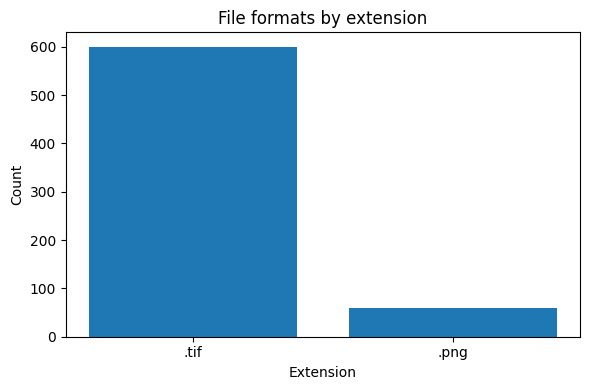

In [9]:
# --- File extensions (formats) ---
import os, collections, matplotlib.pyplot as plt

ext_counts = collections.Counter([os.path.splitext(p)[1].lower() for p in all_paths])
print(ext_counts)

plt.figure(figsize=(6,4))
plt.bar(list(ext_counts.keys()), list(ext_counts.values()))
plt.title("File formats by extension")
plt.xlabel("Extension"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

,count
diagnostic_type,
Malignant (unspecified),260
Normal/Benign,200
In-situ (DCIS),100
Invasive carcinoma,100


,count
acquisition_type,
Unspecified,600
WSI,60


,count
magnification,
None,660


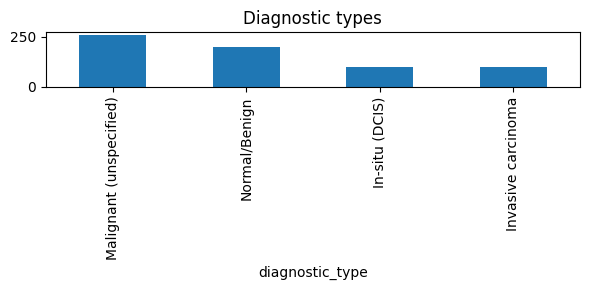

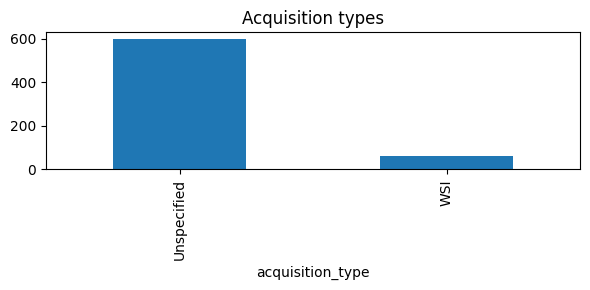

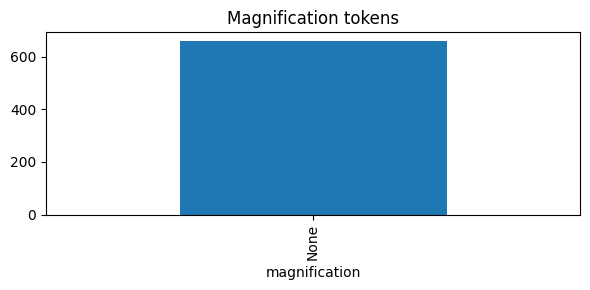

In [11]:
import os, re, collections, pandas as pd, matplotlib.pyplot as plt

# 1) Map paths → diagnostic_type (semantic)
def map_diagnostic(p: str):
    s = p.lower()
    if re.search(r'(normal|control|non[-_ ]?cancer)', s): return "Normal/Benign"
    if re.search(r'(benign)', s):                           return "Normal/Benign"
    if re.search(r'(in[-_ ]?situ|insitu|dcis)', s):         return "In-situ (DCIS)"
    if re.search(r'(invasive|inv[_-]?ca)', s):              return "Invasive carcinoma"
    if re.search(r'(malignant|carcinoma|tumou?r|cancer)', s):
        return "Malignant (unspecified)"
    return None

# 2) Map paths → acquisition_type and magnification tokens
def map_acquisition(p: str):
    s = p.lower()
    if "wsi" in s or "whole-slide" in s or "wholeslide" in s: acq = "WSI"
    elif "patch" in s or "tile" in s or "tiles" in s or "roi" in s: acq = "Patch/Tile/ROI"
    else: acq = "Unspecified"
    mag = None
    for m in ("5x","10x","20x","40x","60x"):
        if m in s: mag = m.upper(); break
    return acq, mag

df_types = pd.DataFrame({"path": all_paths})
df_types["diagnostic_type"] = df_types["path"].map(map_diagnostic)
df_types[["acquisition_type","magnification"]] = df_types["path"].map(map_acquisition).apply(pd.Series)

# Counts you can paste into the report
diag_counts = df_types["diagnostic_type"].value_counts(dropna=False)
acq_counts  = df_types["acquisition_type"].value_counts()
mag_counts  = df_types["magnification"].value_counts(dropna=False)

display(diag_counts.to_frame("count"))
display(acq_counts.to_frame("count"))
display(mag_counts.to_frame("count"))

# Simple bar charts (matplotlib only)
plt.figure(figsize=(6,3)); diag_counts.plot(kind="bar"); plt.title("Diagnostic types"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,3)); acq_counts.plot(kind="bar");  plt.title("Acquisition types"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,3)); mag_counts.plot(kind="bar");  plt.title("Magnification tokens"); plt.tight_layout(); plt.show()